In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Load and shuffle the data
data = pd.read_csv("1 million Trigger Data/outputx2y2V3.csv")
data = data.sample(frac=1, random_state=1)

strip_width = 2 * 3.7 / 64  # Same as before

# Identify relevant columns
x_id_cols = [col for col in data.columns if re.match(r'XStripID\d+', col)]
y_id_cols = [col for col in data.columns if re.match(r'YStripID\d+', col)]
x_energy_cols = [col for col in data.columns if re.match(r'XStripEnergy\d+', col)]
y_energy_cols = [col for col in data.columns if re.match(r'YStripEnergy\d+', col)]

# Adjust positions
if 'ResultPositionX' in data.columns:
    if x_id_cols:
        data['ResultPositionX'] = (data['ResultPositionX'] + 3.7) - data[x_id_cols[0]] * strip_width

if 'ResultPositionY' in data.columns:
    if y_id_cols:
        data['ResultPositionY'] = (data['ResultPositionY'] + 3.7) - data[y_id_cols[0]] * strip_width

data['RelativeEnergy'] = data["XStripEnergy1"]/data["XStripEnergy2"]  # range [-π, π]
data['RelativeEnergy2'] = data["YStripEnergy1"]/data["YStripEnergy2"]
data['RelativeEnergy3'] = data["XStripEnergy1"]/data["YStripEnergy1"]
data['RelativeEnergy4'] = data["XStripEnergy2"]/data["YStripEnergy2"]
data['RelativeEnergy5'] = 1/( data["XStripEnergy2"] + data["YStripEnergy2"])

# Define inputs and outputs
input_features = x_energy_cols + y_energy_cols + ['ResultPositionX', 'ResultPositionY',"RelativeEnergy","RelativeEnergy2", "RelativeEnergy3", "RelativeEnergy4", "RelativeEnergy5"]
output_features = [ "ResultDirectionX", "ResultDirectionY"]

# Normalize data (mean-std scaling) — recommended for better convergence
stats = {"mean": {}, "std": {}}
for col in input_features + output_features:
    mean = data[col].mean()
    std = data[col].std()
    data[col] = (data[col] - mean) / std
    stats["mean"][col] = mean
    stats["std"][col] = std

# Train/test split
test_set = data[:int(len(data) * 0.25)]
data = data[int(len(data) * 0.25):]

X = data[input_features]
y = data[output_features]
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.25, random_state=6)

# Train separate XGBoost models for each output
models = {}
for i, target in enumerate(output_features):
    model = xgb.XGBRegressor(
        n_estimators=1500,
        max_depth=12,
        learning_rate=0.005,
        subsample=0.9,
        colsample_bytree=0.8,
        reg_lambda=1e-5,
        reg_alpha=0,
        tree_method='hist',
        early_stopping_rounds=50
    )
    model.fit(
        X_train, y_train[target],
        eval_set=[(X_dev, y_dev[target])],
        verbose=True
    )
    models[target] = model

# Predictions on test set
X_test = test_set[input_features]
y_test = test_set[output_features]

predictions = {}
for target in output_features:
    pred_scaled = models[target].predict(X_test)
    # Reverse normalization
    pred_rescaled = pred_scaled * stats["std"][target] + stats["mean"][target]
    predictions[target] = pred_rescaled

# Put predictions into DataFrame
predictions_df = pd.DataFrame(predictions)

# Unscale true values for comparison
rescaled_y_test = y_test.copy()
for col in output_features:
    mean = stats["mean"][col]
    std = stats["std"][col]
    rescaled_y_test[col] = y_test[col] * std + mean

# Evaluate: Position Error



[0]	validation_0-rmse:0.99598
[1]	validation_0-rmse:0.99557
[2]	validation_0-rmse:0.99517
[3]	validation_0-rmse:0.99477
[4]	validation_0-rmse:0.99255
[5]	validation_0-rmse:0.99036
[6]	validation_0-rmse:0.98815
[7]	validation_0-rmse:0.98599
[8]	validation_0-rmse:0.98560
[9]	validation_0-rmse:0.98346
[10]	validation_0-rmse:0.98132
[11]	validation_0-rmse:0.97919
[12]	validation_0-rmse:0.97710
[13]	validation_0-rmse:0.97501
[14]	validation_0-rmse:0.97293
[15]	validation_0-rmse:0.97086
[16]	validation_0-rmse:0.97050
[17]	validation_0-rmse:0.96846
[18]	validation_0-rmse:0.96644
[19]	validation_0-rmse:0.96609
[20]	validation_0-rmse:0.96409
[21]	validation_0-rmse:0.96375
[22]	validation_0-rmse:0.96342
[23]	validation_0-rmse:0.96308
[24]	validation_0-rmse:0.96275
[25]	validation_0-rmse:0.96079
[26]	validation_0-rmse:0.95882
[27]	validation_0-rmse:0.95849
[28]	validation_0-rmse:0.95654
[29]	validation_0-rmse:0.95462
[30]	validation_0-rmse:0.95273
[31]	validation_0-rmse:0.95243
[32]	validation_0-

In [2]:
"""x_diff = rescaled_y_test["ResultPositionX"].values - predictions_df["ResultPositionX"].values
y_diff = rescaled_y_test["ResultPositionY"].values - predictions_df["ResultPositionY"].values
diff_distance = np.sqrt(x_diff**2 + y_diff**2)

print("Mean Distance Error:", np.mean(diff_distance))
print("Std of Distance Error:", np.std(diff_distance))"""

# Evaluate: Angle Error
import random
pred_d_x = predictions_df["ResultDirectionX"].values
actual_d_x = rescaled_y_test["ResultDirectionX"].values
pred_d_y = predictions_df["ResultDirectionY"].values
actual_d_y = rescaled_y_test["ResultDirectionY"].values

dot_product = pred_d_x * actual_d_x + pred_d_y * actual_d_y
Mag1 = np.sqrt(pred_d_x**2 + pred_d_y**2)
Mag2 = np.sqrt(actual_d_x**2 + actual_d_y**2)

directions = []
for i in range(len(dot_product)):
    cos_theta = dot_product[i] / (Mag1[i] * Mag2[i] + 1e-8)  # prevent division by zero
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    angle = np.degrees(np.arccos(cos_theta)) * random.choice([-1, 1])
    directions.append(angle)

directions = np.array(directions)
directions = directions[np.isfinite(directions)]

print("Mean Angle Error (degrees):", np.mean(directions))
print("Std Angle Error (degrees):", np.std(np.abs(directions)))

# Optional: plot histograms like you did before
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

plt.figure(figsize=(8, 5))
sns.histplot(diff_distance, bins=100, kde=False, stat='density', color='skyblue', edgecolor='black')
mu, std = norm.fit(diff_distance)
x = np.linspace(min(diff_distance), max(diff_distance), 500)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r--', linewidth=2, label=f'Gaussian Fit\nμ={mu:.2f} cm, σ={std:.2f} cm')
plt.title("XGBoost Position Error Distribution")
plt.xlabel("Error Distance (cm)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

Mean Angle Error (degrees): -0.011871660696871313
Std Angle Error (degrees): 40.270837688775806


NameError: name 'diff_distance' is not defined

<Figure size 800x500 with 0 Axes>

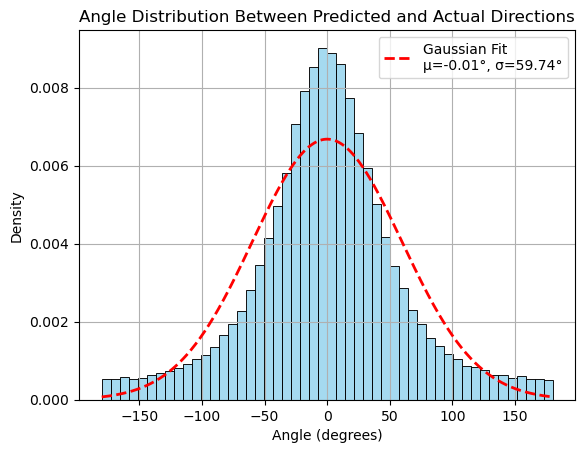

In [3]:
sns.histplot(np.array(directions), bins=50, kde=False, stat='density', color='skyblue', edgecolor='black')

mu, std = norm.fit(directions)
x = np.linspace(min(directions), max(directions), 500)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r--', linewidth=2, label=f'Gaussian Fit\nμ={mu:.2f}°, σ={std:.2f}°')

# Final touches
plt.title("Angle Distribution Between Predicted and Actual Directions")
plt.xlabel("Angle (degrees)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()